## Library installation

In [ ]:
!pip install -q "flwr[simulation]" flwr-datasets

In [ ]:
!pip install transformers

In [ ]:
!pip install torch==1.13.1+cpu torchvision==0.14.1+cpu --extra-index-url https://download.pytorch.org/whl/cpu

In [ ]:
!pip install matplotlib

In [ ]:
!pip install scikit-learn

## Imports

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random

import torch
import torch.nn as nn

import tqdm

from datasets import Dataset, DatasetDict

from sklearn.metrics import accuracy_score, precision_score, recall_score

from torch.utils.data import DataLoader, Subset

from transformers import AutoModel, AutoTokenizer, PreTrainedTokenizer

## Data preprocessing

In [2]:
label_mapping = {
    "negative": 0,
    "neutral": 1,
    "positive": 2,
}

In [3]:
num_partitions = 4

In [4]:
distilbert_tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

In [5]:
def preprocess_data(df: pd.DataFrame) -> pd.DataFrame:
    copied = df[["sentence", "gold_label"]].rename(columns={"sentence": "text", "gold_label": "label"})
    copied = copied[copied.label != "mixed"].dropna()
    copied["label"] = copied["label"].map(label_mapping)

    return copied

In [6]:
def tokenize_data(ds: Dataset, tokenizer: PreTrainedTokenizer) -> pd.DataFrame:
    copied = ds.map(
        lambda s, tok: {
            "ids": (encoded := tok(s["text"], truncation=True, padding=True))["input_ids"],
            "attention_mask": encoded["attention_mask"],
        },
        fn_kwargs={"tok": tokenizer},
    )

    return copied

In [7]:
training_data = [pd.read_json(f"data/partitions/balanced_dirichlet_partition_{i}.jsonl", lines=True) for i in range(num_partitions)]
validation_data = pd.concat([
    preprocess_data(pd.read_json("data/dynasent-v1.1-round01-yelp-test.jsonl", lines=True)),
    preprocess_data(pd.read_json("data/dynasent-v1.1-round01-yelp-dev.jsonl", lines=True)),
], ignore_index=True).drop_duplicates()

In [8]:
training_ds = [tokenize_data(Dataset.from_pandas(df, preserve_index=False), distilbert_tokenizer) for df in training_data]
validation_ds = tokenize_data(Dataset.from_pandas(validation_data, preserve_index=False), distilbert_tokenizer)

Map:   0%|          | 0/11952 [00:00<?, ? examples/s]

Map:   0%|          | 0/11154 [00:00<?, ? examples/s]

Map:   0%|          | 0/14427 [00:00<?, ? examples/s]

Map:   0%|          | 0/10267 [00:00<?, ? examples/s]

Map:   0%|          | 0/7200 [00:00<?, ? examples/s]

In [9]:
training_ds = [ds.with_format(type="torch", columns=["ids", "label", "attention_mask"]) for ds in training_ds]
validation_ds = validation_ds.with_format(type="torch", columns=["ids", "label", "attention_mask"])

In [10]:
def get_data_loader(dataset: Dataset, batch_size: int, pad_index, shuffle=False) -> DataLoader:
    def collate_fn(batch):
        batch_ids = nn.utils.rnn.pad_sequence([i["ids"] for i in batch], padding_value=pad_index, batch_first=True)
        batch_label = torch.stack([i["label"] for i in batch])
        batch_mask = nn.utils.rnn.pad_sequence([i["attention_mask"] for i in batch], padding_value=pad_index, batch_first=True)
        
        return {
            "ids": batch_ids,
            "label": batch_label,
            "attention_mask": batch_mask,
        }
    
    dl = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=shuffle
    )
    
    return dl

In [11]:
training_dl = [get_data_loader(ds, 32, distilbert_tokenizer.pad_token_id, shuffle=True) for ds in training_ds]
validation_dl = get_data_loader(validation_ds, 32, distilbert_tokenizer.pad_token_id)

## Model definition

In [12]:
class Transformer(nn.Module):
    def __init__(self, transformer, num_classes: int, freeze: bool):
        super().__init__()
        
        self.transformer = transformer
        self.fc = nn.Linear(transformer.config.hidden_size, num_classes)
        self.dropout = nn.Dropout(0.3)
        
        if freeze:
            for param in self.transformer.parameters():
                param.requires_grad = False

    
    def forward(self, ids: torch.Tensor, attention_mask: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        output = self.transformer(ids, attention_mask=attention_mask, output_attentions=True)
        pooled_mean = torch.mean(output.last_hidden_state, dim=1)
        cls_hidden = self.dropout(pooled_mean)
        prediction = self.fc(cls_hidden)

        return prediction, output.attentions

In [13]:
distilbert_tf = AutoModel.from_pretrained("distilbert-base-uncased", attn_implementation="eager")

model = Transformer(distilbert_tf, num_classes=3, freeze=False)

## Loading from backup
### Checkpoint loading

In [14]:
r = 8

In [15]:
initial_state_dict = model.state_dict()

In [16]:
checkpoint = torch.load(f"model/fedavg_r{r - 1}.pth")

In [17]:
initial_state_dict = checkpoint["model_state_dict"]

In [18]:
model.load_state_dict(initial_state_dict)

<All keys matched successfully>

## Model configuration

In [19]:
num_parameters = sum(value.numel() for value in model.state_dict().values())
print(f"{num_parameters = }")

num_parameters = 66365187


In [20]:
criterion = torch.nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)
criterion = criterion.to(device)

In [21]:
print(model)

Transformer(
  (transformer): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(in_

## Training and evaluation

In [22]:
def get_accuracy(prediction, label) -> np.float64:
    predicted_classes = prediction.argmax(dim=-1).cpu().numpy()
    actual_labels = label.cpu().numpy()
    
    return accuracy_score(actual_labels, predicted_classes)

def get_precision(prediction, label) -> np.float64:
    predicted_classes = prediction.argmax(dim=-1).cpu().numpy()
    actual_labels = label.cpu().numpy()
    
    return precision_score(actual_labels, predicted_classes, average="macro", zero_division=0)

def get_recall(prediction, label) -> np.float64:
    predicted_classes = prediction.argmax(dim=-1).cpu().numpy()
    actual_labels = label.cpu().numpy()
    
    return recall_score(actual_labels, predicted_classes, average="macro", zero_division=0)

def get_f1_score(precision: np.float64, recall: np.float64) -> np.float64:
    return np.float64(2.0) * (precision * recall) / (precision + recall)

In [23]:
def train(
        net: Transformer,
        data_loader: DataLoader,
        optimizer: torch.optim.Optimizer,
) -> tuple[np.float64, np.float64, np.float64, np.float64, np.float64]:
    net.train()
    
    batch_losses = []
    batch_accuracies = []
    batch_precisions = []
    batch_recalls = []
    
    for batch in tqdm.tqdm(data_loader, desc="Training..."):
        ids = batch["ids"].to(device)
        label = batch["label"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        
        prediction, _ = net(ids, attention_mask)
        
        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        precision = get_precision(prediction, label)
        recall = get_recall(prediction, label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        batch_losses.append(loss.item())
        batch_accuracies.append(accuracy)
        batch_precisions.append(precision)
        batch_recalls.append(recall)

    avg_loss = np.mean(batch_losses)
    avg_accuracy = np.mean(batch_accuracies)
    avg_precision = np.mean(batch_precisions)
    avg_recall = np.mean(batch_recalls)
    f1_score = get_f1_score(avg_precision, avg_recall)
        
    return avg_loss, avg_accuracy, avg_precision, avg_recall, f1_score


def run_local(
        net: Transformer,
        training_loaders: list[DataLoader],
        fl_round: int,
        learning_rate: float,
        client: int,
):
    train_losses = []
    train_accuracies = []
    train_precisions = []
    train_recalls = []
    train_f1_scores = []
    
    optimizer = torch.optim.AdamW(net.parameters(), lr=learning_rate)
        
    train_loss, train_accuracy, train_precision, train_recall, train_f1_score = train(net, training_loaders[client], optimizer)

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    train_precisions.append(train_precision)
    train_recalls.append(train_recall)
    train_f1_scores.append(train_f1_score)

    print(f"{train_loss = }")
    print(f"{train_accuracy = }")
    print(f"{train_precision = }")
    print(f"{train_recall = }")
    print(f"{train_f1_score = }")
    
    torch.save({
        "round": fl_round,
        "model_state_dict": net.state_dict(),
        "train": {
            "loss": train_loss,
            "accuracy": train_accuracy,
            "precision": train_precision,
            "recall": train_recall,
            "f1_score": train_f1_score,
        },
    }, f"model/partition_c{client}_r{fl_round}.pth")


def eval_centralized(
        net: Transformer,
        data_loader: DataLoader,
        fl_round: int,
) -> dict[str, np.float64]:
    net.eval()
    
    batch_losses = []
    batch_accuracies = []
    batch_precisions = []
    batch_recalls = []
    
    with torch.no_grad():
        for batch in tqdm.tqdm(data_loader, desc="Evaluating..."):
            ids = batch["ids"].to(device)
            label = batch["label"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            
            prediction, _ = net(ids, attention_mask)
            
            loss = criterion(prediction, label)
            accuracy = get_accuracy(prediction, label)
            precision = get_precision(prediction, label)
            recall = get_recall(prediction, label)
            
            batch_losses.append(loss.item())
            batch_accuracies.append(accuracy)
            batch_precisions.append(precision)
            batch_recalls.append(recall)

    avg_loss = np.mean(batch_losses)
    avg_accuracy = np.mean(batch_accuracies)
    avg_precision = np.mean(batch_precisions)
    avg_recall = np.mean(batch_recalls)
    f1_score = get_f1_score(avg_precision, avg_recall)

    print(f"{avg_loss = }")
    print(f"{avg_accuracy = }")
    print(f"{avg_precision = }")
    print(f"{avg_recall = }")
    print(f"{f1_score = }")

    metrics = {
        "loss": avg_loss,
        "accuracy": avg_accuracy,
        "precision": avg_precision,
        "recall": avg_recall,
        "f1_score": f1_score,
    }

    return metrics

In [24]:
lr = 1e-6

In [27]:
run_local(net=model, training_loaders=training_dl, fl_round=r, learning_rate=lr, client=0)

Training...: 100%|████████████████████████████████████████████████████████████████████| 374/374 [09:20<00:00,  1.50s/it]

train_loss = 0.4132215520516436
train_accuracy = 0.8231116310160428
train_precision = 0.7855905173515209
train_recall = 0.7155787697077222
train_f1_score = 0.7489520345859156


In [29]:
run_local(net=model, training_loaders=training_dl, fl_round=r, learning_rate=lr, client=1)

Training...: 100%|████████████████████████████████████████████████████████████████████| 349/349 [09:16<00:00,  1.60s/it]

train_loss = 0.7245451486042372
train_accuracy = 0.6827443489334607
train_precision = 0.6573207212042763
train_recall = 0.6366553576270656
train_f1_score = 0.6468230219710811


In [31]:
run_local(net=model, training_loaders=training_dl, fl_round=r, learning_rate=lr, client=2)

Training...: 100%|████████████████████████████████████████████████████████████████████| 451/451 [11:44<00:00,  1.56s/it]

train_loss = 0.7372351671401783
train_accuracy = 0.684920854890367
train_precision = 0.6759521573231091
train_recall = 0.6409383779106734
train_f1_score = 0.6579797905267529


In [33]:
run_local(net=model, training_loaders=training_dl, fl_round=r, learning_rate=lr, client=3)

Training...: 100%|████████████████████████████████████████████████████████████████████| 321/321 [08:18<00:00,  1.55s/it]

train_loss = 0.6609314895493219
train_accuracy = 0.7255538248528902
train_precision = 0.6666802844262496
train_recall = 0.6018240980350529
train_f1_score = 0.6325942052704262


In [32]:
model.load_state_dict(initial_state_dict)

<All keys matched successfully>

In [ ]:
torch.cuda.empty_cache()

### Model saving

In [25]:
def fed_avg(global_model, model_state_dicts):
    ds_lengths = [len(ds) for ds in training_ds]
    total_samples = sum(ds_lengths)
    weights = [l / total_samples for l in ds_lengths]
    
    global_dict = global_model.state_dict()
    
    for k in global_dict.keys():
        global_dict[k] = torch.zeros_like(global_dict[k])
        
        for i in range(len(model_state_dicts)):
            global_dict[k] += model_state_dicts[i][k] * weights[i]
            
    global_model.load_state_dict(global_dict)
    
    return global_model

In [26]:
local_state_dicts = [torch.load(f"model/partition_c{i}_r{r}.pth")["model_state_dict"] for i in range(num_partitions)]
model = fed_avg(model, local_state_dicts)

In [25]:
[torch.load(f"model/partition_c{i}_r{r}.pth")["train"] for i in range(num_partitions)]

FileNotFoundError: [Errno 2] No such file or directory: 'model/partition_c0_r8.pth'

In [ ]:
[torch.load(f"model/fedavg_r{i}.pth")["test"] for i in range(r)]

In [28]:
eval_metrics = eval_centralized(model, validation_dl, r)

Evaluating...: 100%|██████████████████████████████████████████████████████████████████| 225/225 [01:28<00:00,  2.56it/s]

avg_loss = 0.9407069407569038
avg_accuracy = 0.6116666666666667
avg_precision = 0.692162483318495
avg_recall = 0.6109205418605143
f1_score = 0.6490089598187573


In [26]:
checkpoint["test"]

{'loss': 0.9407069407569038,
 'accuracy': 0.6116666666666667,
 'precision': 0.692162483318495,
 'recall': 0.6109205418605143,
 'f1_score': 0.6490089598187573}

In [29]:
torch.save({
    "round": r,
    "model_state_dict": model.state_dict(),
    "test": eval_metrics,
}, f"model/fedavg_r{r}.pth")

### Evaluation Results

In [31]:
client_losses = {i: [] for i in range(r)}
server_losses = []

In [32]:
client_accuracies = {i: [] for i in range(r)}
server_accuracies = []

In [33]:
client_f1_scores = {i: [] for i in range(r)}
server_f1_scores = []

In [34]:
for fl_round in range(r):
    print(f"##### Round {fl_round} #####")

    for client in range(num_partitions):
        print(f"--- Client {client} ---")

        with open(f"model/dirichlet/dirich_partition_c{client}_r{fl_round}.json") as json_data:
            train_metrics = json.load(json_data)["train"]

            client_losses[client].append(train_metrics["loss"])
            client_accuracies[client].append(train_metrics["accuracy"])
            client_f1_scores[client].append(train_metrics["f1_score"])
        
            for metric in train_metrics:
                print(f"{metric} = {train_metrics[metric]}")

    print("--- Aggregated model ---")

    with open(f"model/dirichlet/dirich_fedavg_r{fl_round}.json") as json_data:
        test_metrics = json.load(json_data)["test"]

        server_losses.append(test_metrics["loss"])
        server_accuracies.append(test_metrics["accuracy"])
        server_f1_scores.append(test_metrics["f1_score"])
    
        for metric in test_metrics:
            print(f"{metric} = {test_metrics[metric]}")

##### Round 0 #####
--- Client 0 ---
loss = 0.6773220574792056
accuracy = 0.7340407754010695
precision = 0.3715340427454513
recall = 0.49578278814734444
f1_score = 0.4247586972672561
--- Client 1 ---
loss = 1.0310326625077977
accuracy = 0.5300859598853869
precision = 0.3529028906584616
recall = 0.41132294175464595
f1_score = 0.37988000138914685
--- Client 2 ---
loss = 0.9445406579125483
accuracy = 0.5616146218280365
precision = 0.5099310326583972
recall = 0.4739406988360384
f1_score = 0.4912775969469356
--- Client 3 ---
loss = 0.9531857588580835
accuracy = 0.5902958059305411
precision = 0.21916860617894177
recall = 0.3350036662169278
f1_score = 0.2649800080114825
--- Aggregated model ---
loss = 1.1441355477439032
accuracy = 0.36041666666666666
precision = 0.2934341395397198
recall = 0.3599711998814166
f1_score = 0.3233148948242804
##### Round 1 #####
--- Client 0 ---
loss = 0.5467096079479564
accuracy = 0.7684659090909091
precision = 0.669482653948331
recall = 0.5779728592856301
f1_sco

In [26]:
pth_files = [f for f in os.listdir("model") if f.endswith('.pth')]

In [27]:
for pth in pth_files:
    pth_data = torch.load(f"model/{pth}")
    del pth_data["model_state_dict"]

    with open(f"model/dirich_{pth.removesuffix('.pth')}.json", "w", encoding="utf-8") as json_file:
        json.dump(pth_data, json_file, indent=4)

In [28]:
epoch_rng = range(1, r + 1)

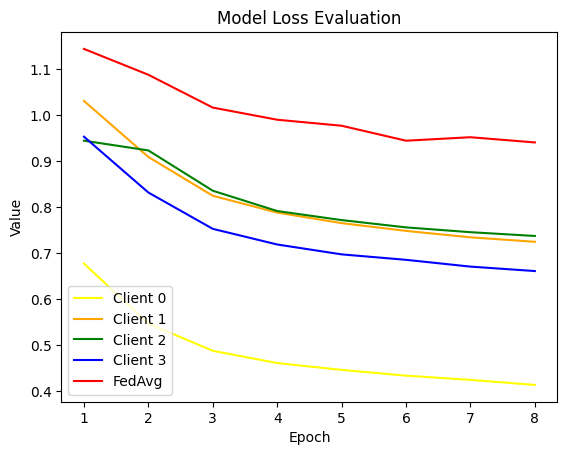

In [35]:
plt.plot(epoch_rng, client_losses[0], label="Client 0", color="yellow")
plt.plot(epoch_rng, client_losses[1], label="Client 1", color="orange")
plt.plot(epoch_rng, client_losses[2], label="Client 2", color="green")
plt.plot(epoch_rng, client_losses[3], label="Client 3", color="blue")
plt.plot(epoch_rng, server_losses, label="FedAvg", color="red")

plt.xlabel("Epoch")
plt.ylabel("Value")

plt.title("Model Loss Evaluation")
plt.legend()
plt.show()

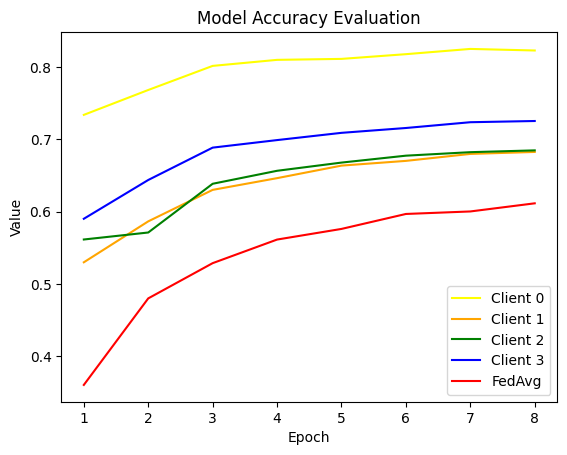

In [36]:
plt.plot(epoch_rng, client_accuracies[0], label="Client 0", color="yellow")
plt.plot(epoch_rng, client_accuracies[1], label="Client 1", color="orange")
plt.plot(epoch_rng, client_accuracies[2], label="Client 2", color="green")
plt.plot(epoch_rng, client_accuracies[3], label="Client 3", color="blue")
plt.plot(epoch_rng, server_accuracies, label="FedAvg", color="red")

plt.xlabel("Epoch")
plt.ylabel("Value")

plt.title("Model Accuracy Evaluation")
plt.legend()
plt.show()

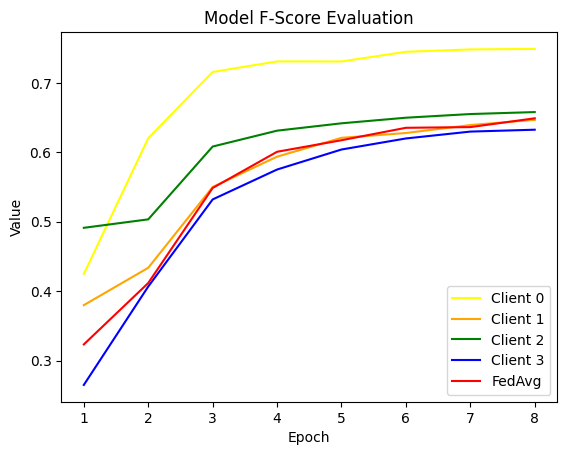

In [37]:
plt.plot(epoch_rng, client_f1_scores[0], label="Client 0", color="yellow")
plt.plot(epoch_rng, client_f1_scores[1], label="Client 1", color="orange")
plt.plot(epoch_rng, client_f1_scores[2], label="Client 2", color="green")
plt.plot(epoch_rng, client_f1_scores[3], label="Client 3", color="blue")
plt.plot(epoch_rng, server_f1_scores, label="FedAvg", color="red")

plt.xlabel("Epoch")
plt.ylabel("Value")

plt.title("Model F-Score Evaluation")
plt.legend()
plt.show()